In [ ]:
! pip install MediaPipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 46.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import cv2
import numpy as np
import mediapipe as mp

# Initialize MediaPipe Hands module
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
# Constant number of frames to extract
FIXED_FRAME_COUNT = 30

def preprocess_and_save_frames(dataset_path, output_path):
    """
    Preprocess all videos using MediaPipe and save the extracted frames into an output directory.
    """
    class_labels = []  # Store class names

    # Get all class folders
    for class_name in sorted(os.listdir(dataset_path)):
        class_folder = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_folder):  # Ensure it's a folder
            class_labels.append(class_name)  # Save class name
            class_output_folder = os.path.join(output_path, class_name)

            # Create output folder for the class if it doesn't exist
            os.makedirs(class_output_folder, exist_ok=True)

            # Process each video in the class folder
            for video_name in os.listdir(class_folder):
                video_path = os.path.join(class_folder, video_name)

                if video_path.endswith(('.MP4', '.mp4', '.mov')):  # Process only video files
                    preprocess_video(video_path, class_output_folder, video_name)

    print(f"Processing completed. Processed frames are saved in: {output_path}")
    return class_labels

def preprocess_video(video_path, output_folder, video_name):

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total number of frames
    frame_interval = total_frames // FIXED_FRAME_COUNT  # Calculate interval between frames
    frame_count = 0  # Counter for naming frames
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
        for i in range(FIXED_FRAME_COUNT):  # Loop through fixed number of frames
            frame_index = i * frame_interval
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  # Set the position to the desired frame
            ret, frame = cap.read()
            if not ret:  # Exit if the video ends
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        image=frame,
                        landmark_list=hand_landmarks,
                        connections=mp_hands.HAND_CONNECTIONS,
                    )
            resized_frame = cv2.resize(frame, (224, 224))
            normalized_frame = resized_frame.astype(np.float32) / 255.0
            frame_filename = f"{os.path.splitext(video_name)[0]}_frame_{frame_count:04d}.png"
            frame_path = os.path.join(output_folder, frame_filename)
            cv2.imwrite(frame_path, (normalized_frame * 255).astype(np.uint8))  # Convert back to [0, 255] range

            frame_count += 1  # Increment frame counter

    cap.release()  # Release the video file

# Example Usage
if __name__ == "__main__":
    dataset_path = '/content/drive/My Drive/dataset'  # Root directory containing class folders
    output_path = '/content/drive/My Drive/preprocessed_frames'  # Directory to save processed frames

    # Preprocess and save frames using MediaPipe
    class_labels = preprocess_and_save_frames(dataset_path, output_path)

    # Example: Show processed dataset information
    print(f"Number of classes processed: {len(class_labels)}")
    print(f"Class names: {class_labels}")


Processing completed. Processed frames are saved in: /content/drive/My Drive/preprocessed_frames
Number of classes processed: 65
Class names: ['Good Morning', 'Good afternoon', 'Hello', 'How are you', 'Thank you', 'are you free today', 'are you hiding something', 'help me', 'how are things', 'how can i help you', 'how can i trust you', 'how dare you', 'how old are you', 'i am (age)', 'i am afraid of that', 'i am crying', 'i am feeling bored', 'i am feeling cold', 'i am fine. thank you sir', 'i am hungry', 'i am in dilemma what to do', 'i am not really sure', 'i am really grateful', 'i am sitting in the class', 'i am so sorry to hear that', 'i am suffering from fever', 'i am tired', 'i am very happy', 'i can not help you there', 'i do not agree', 'i do not like it', 'i do not mean it', 'i dont agree', 'i enjoyed a lot', 'i got hurt', 'i like you i love you', 'i need water', 'i promise', 'i really appreciate it', 'i somehow got to know about it', 'i was stopped by some one', 'it does not

In [ ]:
print(class_labels)

['Good Morning', 'Good afternoon', 'Hello', 'How are you', 'Thank you', 'are you free today', 'are you hiding something', 'help me', 'how are things', 'how can i help you', 'how can i trust you', 'how dare you', 'how old are you', 'i am (age)', 'i am afraid of that', 'i am crying', 'i am feeling bored', 'i am feeling cold', 'i am fine. thank you sir', 'i am hungry', 'i am in dilemma what to do', 'i am not really sure', 'i am really grateful', 'i am sitting in the class', 'i am so sorry to hear that', 'i am suffering from fever', 'i am tired', 'i am very happy', 'i can not help you there', 'i do not agree', 'i do not like it', 'i do not mean it', 'i dont agree', 'i enjoyed a lot', 'i got hurt', 'i like you i love you', 'i need water', 'i promise', 'i really appreciate it', 'i somehow got to know about it', 'i was stopped by some one', 'it does not make any difference to me', 'it was nice chatting with you', 'let him take time', 'my name is xxxxxxxx', 'what are you doing', 'what did you 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training Data
train_data = datagen.flow_from_directory(
    output_path, target_size=(224, 224), batch_size=16, class_mode="categorical", subset="training"
)

# Validation Data
val_data = datagen.flow_from_directory(
    output_path, target_size=(224, 224), batch_size=16, class_mode="categorical", subset="validation"
)

# Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    output_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

Found 9768 images belonging to 65 classes.
Found 2442 images belonging to 65 classes.
Found 12210 images belonging to 65 classes.


In [ ]:
# Define Hybrid CNN + ViT Model
from tensorflow.keras import layers, models

def hybrid_model(input_shape, num_classes, patch_size=16, embedding_dim=64):
    inputs = layers.Input(shape=input_shape)

    # CNN Feature Extraction
    x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    cnn_output = layers.GlobalAveragePooling2D()(x)

    # ViT Patch Embedding
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)  # Compute correctly
    cnn_output_dense = layers.Dense(embedding_dim, activation='relu')(cnn_output)

    # Fix the Reshape Layer
    x = layers.Dense(num_patches * embedding_dim)(cnn_output_dense)  # Ensure correct size
    x = layers.Reshape((num_patches, embedding_dim))(x)  # Reshape properly

    # Multi-Head Attention (ViT Component)
    vit_output = layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(x, x)
    vit_output = layers.GlobalAveragePooling1D()(vit_output)

    # Merge CNN and ViT outputs
    merged = layers.Concatenate()([cnn_output, vit_output])
    x = layers.Dense(512, activation='relu')(merged)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Model Parameters
input_shape = (224, 224, 3)
num_classes = 65  # Adjusted dynamically if needed

# Build Model
model = hybrid_model(input_shape, num_classes)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 222, 222, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 111, 111, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 54, 54, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 52, 52, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 26, 26, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 128)            │              0 │ max_pooling2d_2[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 12544)          │        815,360 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 196, 64)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 196, 64)        │        132,672 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ multi_head_attention[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │         98,816 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 65)             │         33,345 │ dense_2[0][0]          │
└──────────────────────

 Total params: 1,181,697 (4.51 MB)

 Trainable params: 1,181,697 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=35)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.0196 - loss: 4.1187 - val_accuracy: 0.0111 - val_loss: 4.3290
Epoch 2/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 66s 109ms/step - accuracy: 0.0169 - loss: 4.0553 - val_accuracy: 0.0000e+00 - val_loss: 4.7669
Epoch 3/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.0280 - loss: 3.9914 - val_accuracy: 0.0000e+00 - val_loss: 5.3413
Epoch 4/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.0335 - loss: 3.9034 - val_accuracy: 0.0000e+00 - val_loss: 5.8292
Epoch 5/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.0456 - loss: 3.8143 - val_accuracy: 0.0025 - val_loss: 7.6084
Epoch 6/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.0612 - loss: 3.6624 - val_accuracy: 4.0950e-04 - val_loss: 7.7444
Epoch 7/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.0841 - loss: 3.4841 - val_accuracy: 0.0119 - val_loss: 8.8661
Epoch 8/35
611/611 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 

In [ ]:
loss, accuracy = model.evaluate(train_data)
print(f"train Accuracy: {accuracy*100:.2f}%")
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy*100:.2f}%")
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy*100:.2f}%")


611/611 ━━━━━━━━━━━━━━━━━━━━ 53s 86ms/step - accuracy: 0.7752 - loss: 0.7377
train Accuracy: 77.85%
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.1003 - loss: 25.0949
Validation Accuracy: 10.03%
382/382 ━━━━━━━━━━━━━━━━━━━━ 66s 167ms/step - accuracy: 0.6425 - loss: 5.5434
Test Accuracy: 64.28%


In [ ]:
# Save to a specific folder
model.save('/content/drive/My Drive/Models/hybrid_model.h5')
print("Model saved in '/content/drive/My Drive/Models/hybrid_model.h5")

Model saved in '/content/drive/My Drive/Models/hybrid_model.h5


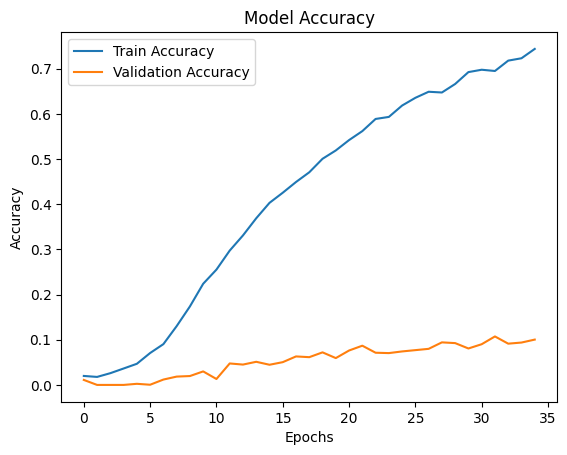

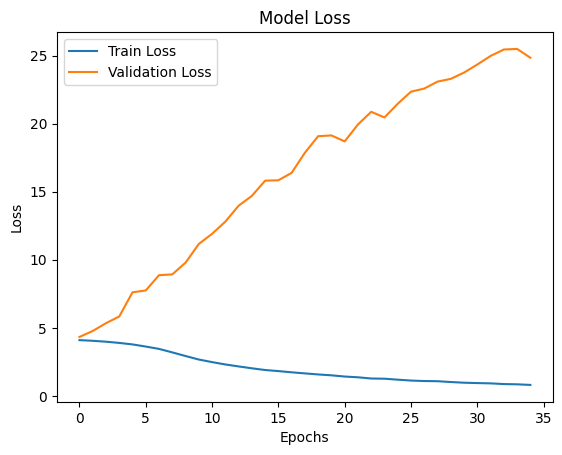

In [ ]:
#  Plot training history
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define dataset path
DATASET_PATH = '/content/drive/My Drive/preprocessed_frames'
IMG_SIZE = 64
NUM_CLASSES = 65
# Load Images and Labels
images = []
labels = []
label_map = {}  # Mapping class names to numbers

for idx, class_name in enumerate(os.listdir(DATASET_PATH)):
    label_map[class_name] = idx  # Assign a number to each class
    class_path = os.path.join(DATASET_PATH, class_name)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
        images.append(img)
        labels.append(idx)

# Convert to NumPy Arrays
images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype("float32") / 255.0
labels = np.array(labels)

# Split into Train & Test
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"Dataset loaded: {x_train.shape[0]} training samples, {x_test.shape[0]} testing samples.")


Dataset loaded: 9768 training samples, 2442 testing samples.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")
        self.flatten = layers.Reshape((-1, embed_dim))  # Flatten patches

    def call(self, x):
        x = self.projection(x)
        x = self.flatten(x)
        return x

class ViTBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super().__init__()
        self.norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm2 = layers.LayerNormalization()
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dense(embed_dim),
        ])
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x):
        attn_output = self.attn(x, x)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.mlp(x))
        return x

def build_cnn_vit(input_shape, num_classes, patch_size=4, embed_dim=64, num_heads=4, mlp_dim=128, num_vit_layers=3):
    inputs = keras.Input(shape=input_shape)

    # CNN Feature Extractor
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convert feature maps to patches for ViT
    x = PatchEmbedding(patch_size, embed_dim)(x)

    # Add learnable class token using a Lambda layer
    class_token = tf.Variable(tf.zeros((1, 1, embed_dim)), trainable=True)

    def add_class_token(inputs):
        batch_size = tf.shape(inputs)[0]
        cls_token = tf.tile(class_token, [batch_size, 1, 1])
        return tf.concat([cls_token, inputs], axis=1)

    x = layers.Lambda(add_class_token)(x)  # Fix applied here ✅

    # Vision Transformer Encoder
    for _ in range(num_vit_layers):
        x = ViTBlock(embed_dim, num_heads, mlp_dim)(x)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(x)  # Pool class token
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model


In [ ]:
# Define input shape (grayscale frames)
input_shape = (64, 64, 1)  # Resized frame size

# Number of classes in the dataset
num_classes = 65  # Adjust this

# Build the CNN + ViT model
model = build_cnn_vit(input_shape, num_classes)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model


Epoch 1/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.0207 - loss: 4.1681 - val_accuracy: 0.0147 - val_loss: 4.3120
Epoch 2/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0393 - loss: 3.8708 - val_accuracy: 0.0471 - val_loss: 3.6672
Epoch 3/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0556 - loss: 3.6172 - val_accuracy: 0.0545 - val_loss: 3.5789
Epoch 4/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0471 - loss: 3.6409 - val_accuracy: 0.0397 - val_loss: 3.8255
Epoch 5/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0736 - loss: 3.4510 - val_accuracy: 0.0319 - val_loss: 3.8137
Epoch 6/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0803 - loss: 3.2754 - val_accuracy: 0.0426 - val_loss: 4.0122
Epoch 7/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1000 - loss: 3.2008 - val_accuracy: 0.0770 - val_loss: 3.2400
Epoch 8/40
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1081 - loss: 3.1035 - val_accura

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7003 - loss: 0.8691 - val_accuracy: 0.5725 - val_loss: 1.3867
Epoch 2/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7196 - loss: 0.7980 - val_accuracy: 0.5233 - val_loss: 1.6899
Epoch 3/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7548 - loss: 0.7342 - val_accuracy: 0.7359 - val_loss: 0.7829
Epoch 4/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7053 - loss: 0.8637 - val_accuracy: 0.2449 - val_loss: 5.3462
Epoch 5/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7414 - loss: 0.7499 - val_accuracy: 0.7363 - val_loss: 0.8128
Epoch 6/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7445 - loss: 0.7405 - val_accuracy: 0.3436 - val_loss: 2.8163
Epoch 7/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7496 - loss: 0.7258 - val_accuracy: 0.7678 - val_loss: 0.7387
Epoch 8/15
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7416 - loss: 0.7392 - val_accurac

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6244 - loss: 1.3963

Test Accuracy: 63.02%


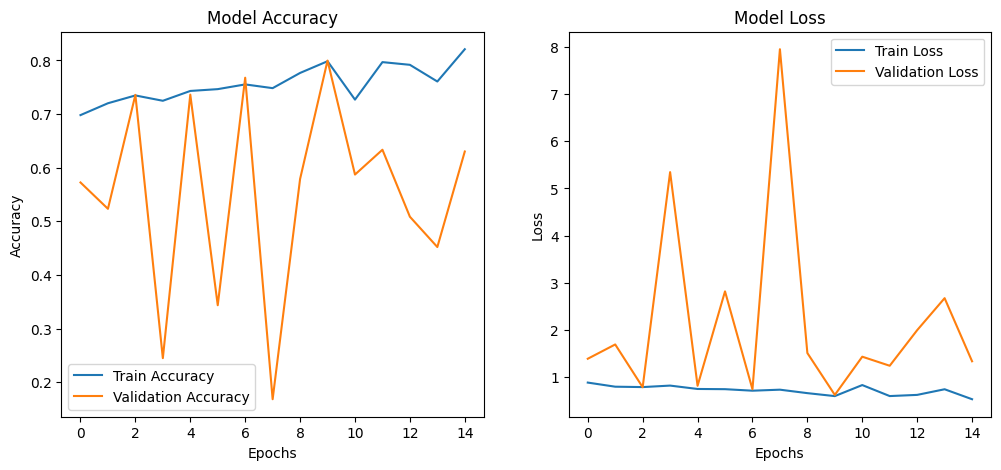

In [ ]:
import matplotlib.pyplot as plt

# Evaluate Model on Test Data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Function to Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss")

    plt.show()

# Plot training results
plot_history(history)


In [ ]:
# Save to a specific folder
model.save('/content/drive/My Drive/Models/hybrid_model_1.h5')
print("Model saved in '/content/drive/My Drive/Models/hybrid_model_1.h5")

Model saved in '/content/drive/My Drive/Models/hybrid_model_1.h5


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from collections import Counter  # For majority voting

# Load the trained model
# model = load_model("/content/drive/My Drive/cnn_vit_model.h5")


# Define class labels (Update this based on your dataset)
class_labels = {
    0: "Good Morning",
    1: "Good Afternoon",
    2: "Hello",
    3: "How are you",
    4: "Thank you",
    5: "Are you free today",
    6: "Are you hiding something",
    7: "Help me",
    8: "How are things",
    9: "How can I help you",
    10: "How can I trust you",
    11: "How dare you",
    12: "How old are you",
    13: "I am (age)",
    14: "I am afraid of that",
    15: "I am crying",
    16: "I am feeling bored",
    17: "I am feeling cold",
    18: "I am fine. Thank you sir",
    19: "I am hungry",
    20: "I am in dilemma what to do",
    21: "I am not really sure",
    22: "I am really grateful",
    23: "I am sitting in the class",
    24: "I am so sorry to hear that",
    25: "I am suffering from fever",
    26: "I am tired",
    27: "I am very happy",
    28: "I can not help you there",
    29: "I do not agree",
    30: "I do not like it",
    31: "I do not mean it",
    32: "I don't agree",
    33: "I enjoyed a lot",
    34: "I got hurt",
    35: "I like you, I love you",
    36: "I need water",
    37: "I promise",
    38: "I really appreciate it",
    39: "I somehow got to know about it",
    40: "I was stopped by someone",
    41: "It does not make any difference to me",
    42: "It was nice chatting with you",
    43: "Let him take time",
    44: "My name is XXXXXXXX",
    45: "What are you doing",
    46: "What did you tell him",
    47: "What do you do",
    48: "What do you think",
    49: "What do you want to become",
    50: "What happened",
    51: "What have you planned for your career",
    52: "What is your phone number",
    53: "What do you want",
    54: "When will the train leave",
    55: "Where are you from",
    56: "Which college/school are you from",
    57: "Who are you",
    58: "Why are you angry",
    59: "Why are you crying",
    60: "Why are you disappointed",
    61: "You are bad",
    62: "You are good",
    63: "You are welcome",
    64: "You can do it"
}



# Function to preprocess frames
def preprocess_frame(frame, target_size=(64, 64)):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, target_size)  # Resize to match model input
    frame = frame.astype("float32") / 255.0  # Normalize
    frame = np.expand_dims(frame, axis=-1)  # Add channel dimension
    return frame

# Function to extract frames from video
def extract_frames(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        frame = preprocess_frame(frame)  # Preprocess the frame
        frames.append(frame)

    cap.release()
    return np.array(frames)  # Shape: (num_frames, 64, 64, 1)

# Load video and preprocess frames
video_path = "/content/drive/My Drive/dataset/are you free today/free (2).MP4"  # Change this to your video file
frames = extract_frames(video_path)

# Loop through frames and predict each one individually
predictions = []
for frame in frames:
    frame = np.expand_dims(frame, axis=0)  # Shape: (1, 64, 64, 1)
    prediction = model.predict(frame)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get class index
    predictions.append(predicted_class)

# Use majority voting to determine the final predicted class for the video
final_class_index = Counter(predictions).most_common(1)[0][0]
final_class_name = class_labels[final_class_index]  # Convert index to label

print(f"Final Predicted Class for Video: {final_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━